<a href="https://colab.research.google.com/github/abhiraman/Capstone_Project/blob/main/Clubbed_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Syncing With GitHub


In [9]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [1]:
# Clone the entire repo.
!git clone https://github.com/abhiraman/Capstone_Project.git


Cloning into 'Capstone_Project'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 103 (delta 38), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (103/103), 5.82 MiB | 9.28 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [13]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=ab6adde914792f9228741a79d80f76aaf4a6e17122389adae6d50186a5817c47
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [14]:
import os
import random
from google.colab.patches import cv2_imshow
import cv2
import json
from pprint import pprint
import PIL as pl
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg


In [18]:
from detectron2.utils.visualizer import Visualizer

In [19]:
%cd /gdrive/My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition
!ls

/gdrive/My Drive/Capstone_project_data/Synthetic Train Set - Detection & Recognition
Annotation  Images     Obj_config.yml  readme.txt
clone-repo  input.jpg  output	       train_crop_annot.txt


In [20]:
cfg = get_cfg()
cfg.merge_from_file("Obj_config.yml")
predictor = DefaultPredictor(cfg)

In [21]:
%cd /gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images
!ls

/gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images
1514.jpg  3067.jpg  3548.jpg  3574.jpg	4350.jpg


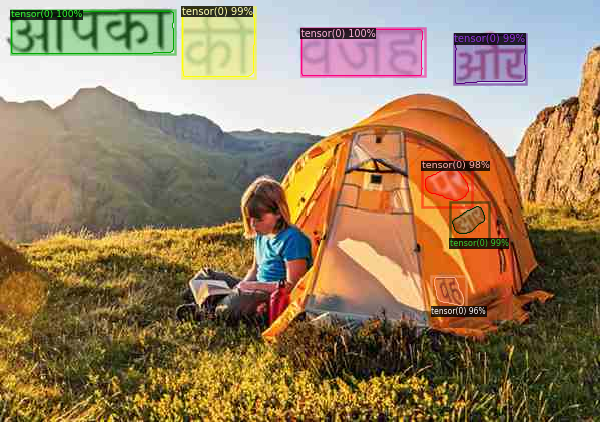

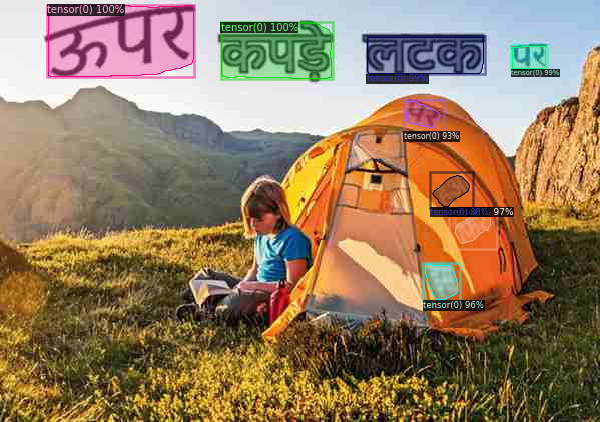

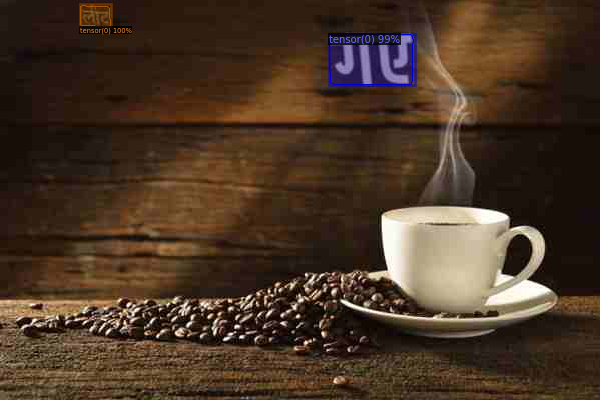

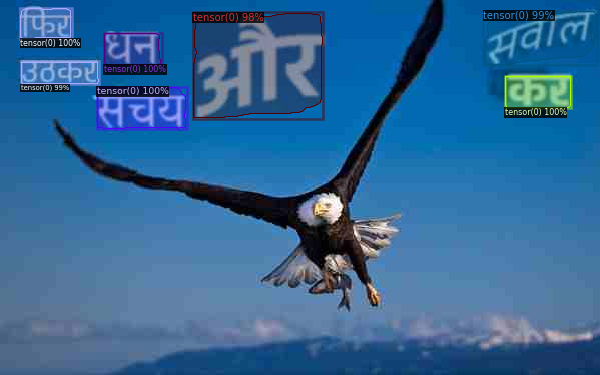

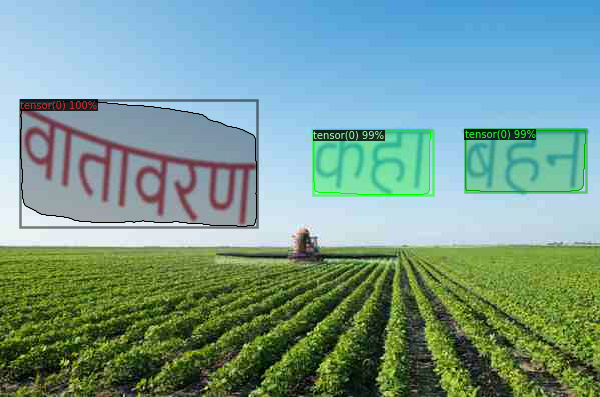

predBox_dims ---->   {'/gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images/3548.jpg': [[11.186205863952637, 175.2101593017578, 175.2101593017578, 11.186205863952637, 10.49257755279541, 10.49257755279541, 54.06877517700195, 54.06877517700195], [300.8085632324219, 425.21978759765625, 425.21978759765625, 300.8085632324219, 28.425777435302734, 28.425777435302734, 76.18428802490234, 76.18428802490234], [454.37860107421875, 526.1710815429688, 526.1710815429688, 454.37860107421875, 33.86711883544922, 33.86711883544922, 84.00060272216797, 84.00060272216797], [181.6981964111328, 255.21337890625, 255.21337890625, 181.6981964111328, 6.539124965667725, 6.539124965667725, 77.83626556396484, 77.83626556396484], [449.8235778808594, 488.6755065917969, 488.6755065917969, 449.8235778808594, 202.4373321533203, 202.4373321533203, 238.98361206054688, 238.98361206054688], [421.91632080078125, 472.2648620605469, 472.2648620605469, 421.91632080078125, 161.3211669921875, 161.3211669921875, 207.28089

In [22]:
from detectron2.utils.visualizer import ColorMode
def _get_all_box_coords(x1,y1,x3,y3):
    x2 = x3
    x4 = x1
    y2 = y1
    y4=y3
    return [x1,x2,x3,x4,y1,y2,y3,y4]


def _infer_obj_detection(image_dir,image,predictor):   
  full_path = os.path.join(image_dir,image)
  inputs = cv2.imread(full_path)
  outputs = predictor(inputs)
  v = Visualizer(inputs[:, :, ::-1],metadata=None,scale=1,instance_mode=ColorMode.IMAGE_BW )  # remove the colors of unsegmented pixels. This option is only available for segmentation models
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  return outputs["instances"]._fields["pred_boxes"].tensor.tolist()

imgDir = '/gdrive/My Drive/Capstone_project_data/Demo Folder/Demo Images'
infoDict = {}
for eImg in os.listdir(imgDir):
  predBox_dims = _infer_obj_detection(imgDir,eImg,predictor)
  for eBox_info in predBox_dims:
    x1,y1,x3,y3 = eBox_info
    allboxInfo = _get_all_box_coords(x1,y1,x3,y3)
    infoDict.setdefault(os.path.join(imgDir,eImg),[]).append(allboxInfo)

print("predBox_dims ---->  ",infoDict)
annotFolder = '/gdrive/My Drive/Capstone_project_data/Demo Folder'
json_file = "box_annot.json"
with open(os.path.join(annotFolder,json_file),'w') as fh:
  json.dump(infoDict,fh)
fh.close()

In [23]:
def _removeFiles_in_dir(directory):
  dirList = os.listdir(directory)
  if dirList!=[]:
    for efileName in dirList:
      if os.path.isdir(os.path.join(directory,efileName)):
        dirPath = os.path.join(directory,efileName)
        [os.remove(os.path.join(dirPath,efileName)) for efileName in os.listdir(dirPath)]
        os.rmdir(dirPath)
      else:
        os.remove(os.path.join(directory,efileName))

In [24]:
def _trim_validation_images(img_dir,infoDict,cropped_imgs_dir):
  for e_image,boxList in infoDict.items():
    file_name = str(e_image.split('/')[-1].split('.')[0])
    try:
      os.mkdir(os.path.join(cropped_imgs_dir,str(file_name)))
    except:
      _removeFiles_in_dir(os.path.join(cropped_imgs_dir,str(file_name)))
    for ind,posList in enumerate(boxList):
        px = posList[0:4]
        py = posList[4:8]
        im = Image.open(e_image)
        crop_image = im.crop((px[0]+.75,py[0]+.75,px[2]+.75,py[2]+.75))
        data = np.asarray(crop_image)
        resize_img = cv2.resize(data,(128,128),fx=1,fy=2,interpolation=cv2.INTER_CUBIC)
        data = np.asarray(resize_img)
        _filter_bacground(data)
        new_img_path = os.path.join(cropped_imgs_dir,str(file_name),str(ind)+".jpg")
        new_img_path = r'{}'.format(new_img_path)
        cv2.imwrite(new_img_path,data)

def _filter_bacground(img):
    #img = cv2.imread(img)
    gray  = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU|cv2.THRESH_BINARY)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    opening  = cv2.morphologyEx(thresh,cv2.MORPH_DILATE,kernel,iterations=3)
    opening  = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=3)

    result =cv2.GaussianBlur(opening,(1,1),0)
    result  = cv2.morphologyEx(result,cv2.MORPH_DILATE,kernel,iterations=3)
    cv2.cvtColor(result,cv2.COLOR_GRAY2RGB)
    cv2.addWeighted(result, 50., result, 0, 50.)

In [25]:
%cd '/gdrive/My Drive/Capstone_project_data/Demo Folder'
!ls

/gdrive/My Drive/Capstone_project_data/Demo Folder
 box_annot.json   cropped_images  'Demo Images'   Img_Text_Recognition.pt


In [26]:
parent_path = r'/gdrive/My Drive/Capstone_project_data/Demo Folder'
crop_Directory = os.path.join(parent_path,"cropped_images")
try:
  os.mkdir(crop_Directory)
except FileExistsError:
  _removeFiles_in_dir(crop_Directory)

predFile = os.path.join(parent_path,json_file)
with open(predFile,'r') as fh:
  infoDict = json.load(fh)
print("loaded json")
_trim_validation_images(imgDir,infoDict,crop_Directory)

loaded json


**Image To text Model**

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import random
import numpy as np
import time
import pandas as pd
from torchvision import transforms
from collections import OrderedDict
from skimage import io
import matplotlib

In [8]:
class RCNN(nn.Module):
  def __init__(self,imgChannel,imgHeight,imgWidth,output_size,mapHidden=64,rnn_hidden =256,leaky_relu=False,verbose=False):
    super().__init__()
    self.verbose = verbose
    self.encoder,(n_channels,height,width) = self._cnn_backbone(imgChannel,imgHeight,imgWidth,leaky_relu)
    self.map_to_seq = nn.Linear(n_channels*height,mapHidden) ## mapHidden > len(hindivocab)
    self.rnn1 = nn.LSTM(mapHidden,rnn_hidden)
    self.dense = nn.Linear(rnn_hidden,output_size)
    self.softMAX = nn.Softmax(dim = 2)
    self.verbose = verbose
    
  def _cnn_backbone(self,img_channel,img_height,img_width,leaky_relu):
    self.encoder = nn.Sequential()
    assert img_height % 16 == 0
    assert img_width % 4 == 0

    channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
    kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
    strides = [1, 1, 1, 1, 1, 1, 1]
    paddings = [1, 1, 1, 1, 1, 1, 0]

    cnn = nn.Sequential()
    def conv_relu(i, batch_norm=False):
      # shape of input: (batch, input_channel, height, width)
      input_channel = channels[i]
      output_channel = channels[i+1]

      cnn.add_module(
          f'conv{i}',
          nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i])
      )

      if batch_norm:
          cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

      relu = nn.LeakyReLU(0.2, inplace=True) if leaky_relu else nn.ReLU(inplace=True)
      cnn.add_module(f'relu{i}', relu)
    
    conv_relu(0)
    cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2))
    # (64, img_height // 2, img_width // 2)

    conv_relu(1)
    cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
    # (128, img_height // 4, img_width // 4)

    conv_relu(2)
    conv_relu(3)
    cnn.add_module(
        'pooling2',
        nn.MaxPool2d(kernel_size=(2, 1))
    )  # (256, img_height // 8, img_width // 4)

    conv_relu(4, batch_norm=True)
    conv_relu(5, batch_norm=True)
    cnn.add_module(
        'pooling3',
        nn.MaxPool2d(kernel_size=(2, 1))
    )  # (512, img_height // 16, img_width // 4)

    conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)

    output_channel, output_height,output_width = \
        channels[-1], img_height // 16 - 1, img_width // 4 - 1
    return cnn, (output_channel, output_height,output_width)

  def forward(self,x,train=True):
    conv = self.encoder(x)
    if self.verbose:
      print("Input Shape : ",x.size())
      print("Encoder Output : ",conv.size())

    batch, channel, height, width = conv.size()
    conv = conv.view(batch, channel * height, width)
    conv = conv.permute(2, 0, 1)  # (width, batch, feature)
    seq = self.map_to_seq(conv)
    recurrent, _ = self.rnn1(seq)
    output = self.dense(recurrent)
    if not train:
      output = self.softMAX(output)
    if self.verbose:
      print("Input to Decoder : ",seq.size())
      print("RNN Output : ",recurrent.size())
      print("Decoder Ouptput : ",output.size())

    return output

In [88]:
%cd /gdrive/My Drive/Capstone_project_data/ImgtoText/Cropped_Images/cropped_data
!ls

/gdrive/My Drive/Capstone_project_data/ImgtoText/Cropped_Images/cropped_data
annotations.txt  Img_Text_Recognition.pt    readme.txt
cropped_dir	 model_Text_Recognition.pt


In [89]:
net = RCNN(3,128,128,130,verbose=False)
checkpoint = torch.load('Img_Text_Recognition.pt')
net.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

In [90]:

def _return_collapsedIndexes(idxList):
  idxList = idxList.squeeze(1).int().tolist()
  cleanedList = []
  for ind,wordInd in enumerate(idxList):
    if ind==0:
      cleanedList.append(wordInd)
      continue
    if cleanedList[-1] ==wordInd:continue
    else:cleanedList.append(wordInd)
  return cleanedList

def _convertSource_toList(source):
  source = source.detach()
  source_idx = torch.argmax(source,dim=2)
  collapsedIndexs = _return_collapsedIndexes(source_idx)
  return collapsedIndexs
  
def _convertIndex_toString(indexx):
  def _get_vocabList():
    blank,padChar = '-','<PAD>'
    all_hindi_alpha = [blank,padChar]+[chr(i) for i in range(2304,2432)]
    all_hindi_alpha = {all_hindi_alpha[i]:i for i in range(len(all_hindi_alpha))} 
    return all_hindi_alpha
  
  VocabList = _get_vocabList()
  k,v = list(VocabList.keys()),list(VocabList.values())
  ss = ''
  for i in indexx:
    if i == 0:
      continue
    ss+=k[v.index(i)]
  return ss




In [91]:
%cd '/gdrive/My Drive/Capstone_project_data/Demo Folder/cropped_images'
!ls

/gdrive/My Drive/Capstone_project_data/Demo Folder/cropped_images
1514  3067  3548  3574	4350


In [92]:
def _get_image_tensor(image_path):
  def _transform_image(imgTensor):
    transform_batch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    imgTensor = transform_batch(imgTensor)
    return imgTensor
  img_tensor = io.imread(image_path)
  img_tensor = _transform_image(img_tensor)
  return img_tensor.unsqueeze(0)

In [ ]:
trimmedImages_path = "/gdrive/My Drive/Capstone_project_data/Demo Folder/cropped_images"
randDirectory = random.sample(os.listdir(trimmedImages_path),1)[0]
for eImage in os.listdir(os.path.join(trimmedImages_path,randDirectory)):
  imgtensor = _get_image_tensor(os.path.join(trimmedImages_path,randDirectory,eImage))
  predtensor = net(imgtensor,train=False)
  sourceList = list(_convertSource_toList(predtensor))
  pred_hindiWord = _convertIndex_toString(sourceList)
  print(pred_hindiWord)